(quickstart)=

# Quickstart 

In [1]:
%config InlineBackend.figure_format = "retina"

import os
import sys
sys.path.insert(0, os.path.abspath('../../../'))

The easiest way to get started with using emcee is to use it for a project. To get you started, here’s an annotated, fully-functional example that demonstrates a standard usage pattern.

## How to sample a multi-dimensional Gaussian

We’re going to demonstrate how you might draw samples from the multivariate Gaussian density given by:

$$
p(\vec{x}) \propto \exp \left [ - \frac{1}{2} (\vec{x} -
    \vec{\mu})^\mathrm{T} \, \Sigma ^{-1} \, (\vec{x} - \vec{\mu})
    \right ]
$$

where $\vec{\mu}$ is an $N$-dimensional vector position of the mean of the density and $\Sigma$ is the square N-by-N covariance matrix.

The first thing that we need to do is import the necessary modules:

Then, we’ll code up a Python function that returns the density $p(\vec{x})$ for specific values of $\vec{x}$, $\vec{\mu}$ and $\Sigma^{-1}$. In fact, emcee actually requires the logarithm of $p$. We’ll call it `log_prob`:

It is important that the first argument of the probability function is
the position of a single "walker" (a *N* dimensional
`numpy` array). The following arguments are going to be constant every
time the function is called and the values come from the `args` parameter
of our {class}`EnsembleSampler` that we'll see soon.

Now, we'll set up the specific values of those "hyperparameters" in 5
dimensions:

and where `cov` is $\Sigma$.

How about we use 32 walkers? Before we go on, we need to guess a starting point for each
of the 32 walkers. This position will be a 5-dimensional vector so the
initial guess should be a 32-by-5 array.
It's not a very good guess but we'll just guess a
random number between 0 and 1 for each component:

Now that we've gotten past all the bookkeeping stuff, we can move on to
the fun stuff. The main interface provided by `emcee` is the
{class}`EnsembleSampler` object so let's get ourselves one of those:

In [2]:
import asteca
import numpy as np
import pandas as pd

Remember how our function `log_prob` required two extra arguments when it
was called? By setting up our sampler with the `args` argument, we're
saying that the probability function should be called as:

In [3]:
# Isochrones parameters
isochs = asteca.isochrones(
    isochs_path="../_static/parsec/",
    magnitude={"Gmag": 6390.21},
    color={"G_BPmag": 5182.58, "G_RPmag": 7825.08},
)

Processing PARSEC isochrones for 1 photometric systems, Nz=1, Na=10...
Finished loading isochrone file(s)


In [4]:
# Synthetic clusters parameters
synthcl = asteca.synthetic(isochs)

Generating binary data
Obtaining extinction coefficients
Sampling selected IMF (kroupa_2001)
Finished generating parameters for synthetic clusters


 asdasdasd asdas dasd asd

In [5]:
# Define likelihood
likelihood = asteca.likelihood()

a dfsd fsd fsd fs dfsd

In [6]:
cluster_df = pd.read_csv("../_static/cluster.csv")

asdasd asdas dadas d

In [7]:
# Cluster parameters
my_cluster = asteca.cluster(
    source_id='Source',
    ra='RA_ICRS',
    dec='DE_ICRS',
    magnitude="Gmag",
    e_mag="e_Gmag",
    color="BP-RP",
    e_color='e_BP-RP',
    cluster_df=cluster_df,
    model_fixed={"z": 0.0152, "DR": 0, "Rv": 3.1, "beta": 0.62}
)

Reading and processing cluster data


asdasd as d asd as  dasdasd

In [8]:
max_lkl = likelihood.get(my_cluster)

def model(model_fit):
    """Generate synthetic cluster"""
    synth_clust = synthcl.generate(my_cluster, model_fit)
    # pyABC expects a dictionary from this function
    return {"data": synth_clust}

def distance(synth, obs):
    """
    The likelihood is maximized for better fitted models but this distance requires
    minimization. Hence we normalize and invert.
    """
    lkl = likelihood.get(my_cluster, synth["data"])
    return 1 - lkl / max_lkl

#
_, _, loga_min, loga_max = isochs.min_max()
dm_min, dm_max = 6, 11
Av_min, Av_max = 0, 2

priors = {
    "loga": [loga_min, loga_max],
    "dm": [dm_min, dm_max],
    "Av": [Av_min, Av_max],
}

synthcl.adjust_mass_sampling(my_cluster, dm_min)

In [ ]:
import pyabc
import tempfile  # Used by pyABC
import datetime as dt  # Used by pyABC

priors = pyabc.Distribution(
    **{
        p: pyabc.RV("uniform", priors[p][0], priors[p][1] - priors[p][0])
        for p in priors
    }
)

# Define pyABC parameters
pop_size = 100
abc = pyabc.ABCSMC(
    model,
    priors,
    distance,
    population_size=pop_size,
    sampler=pyabc.sampler.MulticoreEvalParallelSampler(n_procs=1),
)

# This is a temporary file required by pyABC
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "pyABC.db")
abc.new(db_path)

In [ ]:
# Run pyABC
max_mins = 1
history = abc.run(max_walltime=dt.timedelta(hours=0, minutes=max_mins))

Av 0.4279346918873085 0.013367797448002558
dm 8.20788344011113 0.005898843388341002
loga 7.8977301579996615 0.004271606599361457
ESS: 79.67099322669647
Dist: 0.02062189367203752


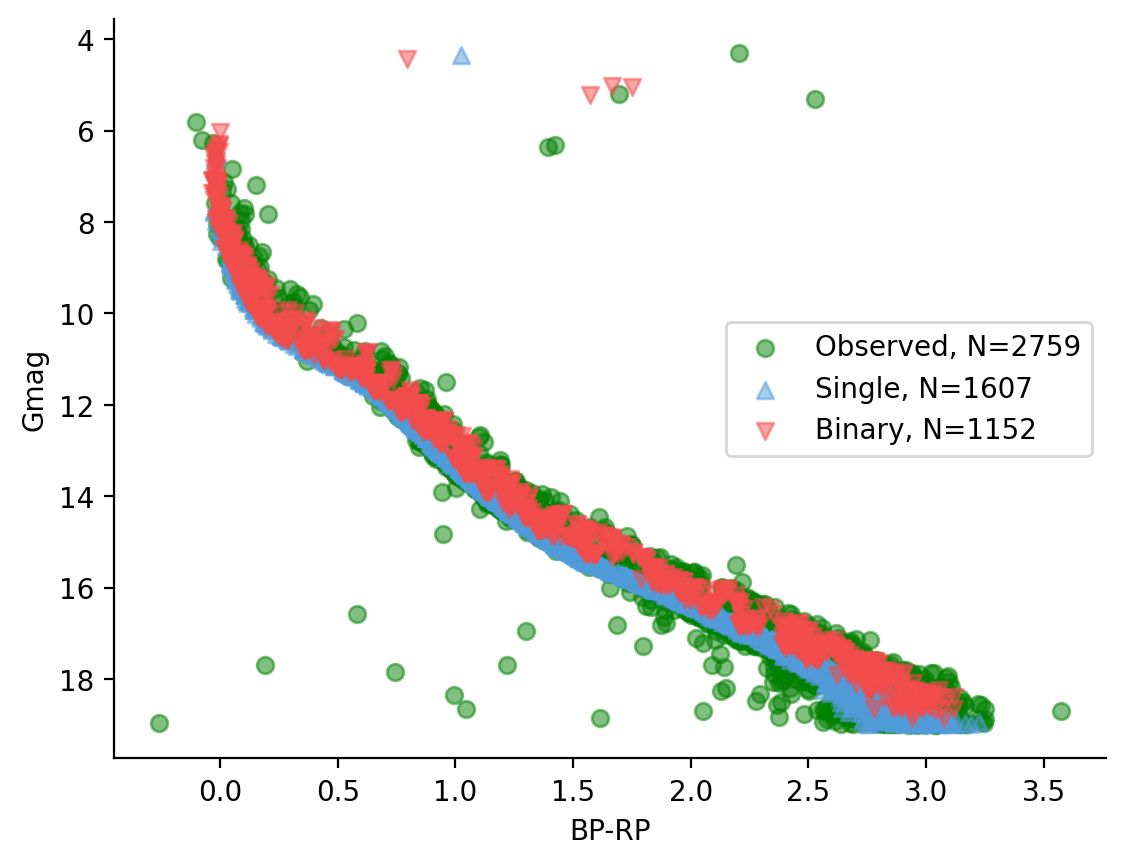

In [13]:
# Extract last iteration and weights
df, w = history.get_distribution()


for k in df.keys():
    _median = pyabc.weighted_statistics.weighted_median(df[k].values, w)
    _std = pyabc.weighted_statistics.weighted_std(df[k].values, w)
    print(k, _median, _std)
print(f"ESS: {pyabc.weighted_statistics.effective_sample_size(w)}")
final_dist = pyabc.inference_util.eps_from_hist(history)
print(f"Dist: {final_dist}")

# Estimate masses and binarity fraction
model_fit = {k: pyabc.weighted_statistics.weighted_median(df[k].values, w) for k in df.keys()}
my_cluster.clust_plot(synthcl, model_fit)

array([[<Axes: ylabel='Av'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='dm'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='Av', ylabel='loga'>, <Axes: xlabel='dm'>,
        <Axes: xlabel='loga'>]], dtype=object)

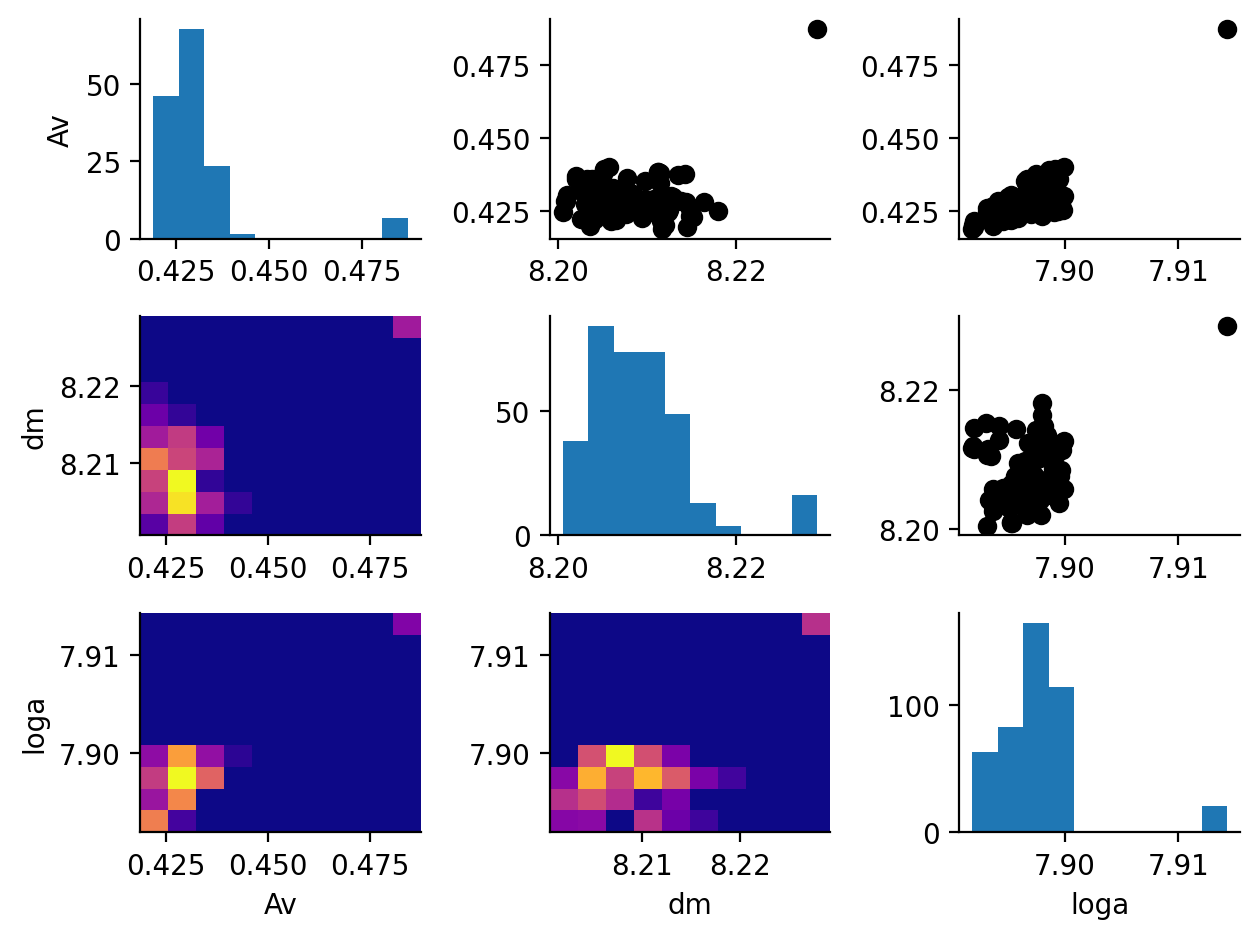

In [14]:
pyabc.settings.set_figure_params("pyabc")
pyabc.visualization.plot_histogram_matrix(history)